In [ ]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt

# !pip install lightgbm
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
# !pip install optuna
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna import Trial

import seaborn as sns


In [ ]:
building = pd.read_csv('building_metadata.csv')
weather_train = pd.read_csv("weather_train.csv")
train_raw = pd.read_csv("train.csv")
weather_test = pd.read_csv("weather_test.csv")
test_raw = pd.read_csv("test.csv")

In [ ]:
building

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [ ]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [ ]:
train_raw

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [ ]:
train_raw['timestamp'].describe()

<ipython-input-30-bc793a00e6a8>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_raw['timestamp'].describe()


count                20216100
unique                   8784
top       2016-12-27 22:00:00
freq                     2370
first     2016-01-01 00:00:00
last      2016-12-31 23:00:00
Name: timestamp, dtype: object

In [ ]:
def resample_data(df, weather, building):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    weather['timestamp'] = pd.to_datetime(weather['timestamp'])
    df['hour'] = df['timestamp'].dt.hour
    df = df[df['meter'] == 0]                         # for simplisity only consider meter 0
    df = df[(df['hour'] == 0) | (df['hour'] == 12)]  # shrink dataset
    df = df.merge(building, on = 'building_id',how = 'left')
    df = df.merge(weather, on = ["site_id", "timestamp"], how = 'left')
  
    return df


In [ ]:
train = resample_data(train_raw, weather_train, building)

In [ ]:
def add_features(df):
    
    # add time features 
    df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df['age'] = df["timestamp"].dt.year - df['year_built']
    drop = ['timestamp']
    drop.append('year_built')
    
         
    # normalize labels
    for i in df.columns:
        if df[i].dtype == object:
            df[i] = le.fit_transform(df[i])
    df = df.drop(drop, axis = 1)

    return df

def clean_data(df):
    
    # basic and general method to deal with outlier 
    # however, for accuracy, deal with outliers differently in different situation
    q_low = df["meter_reading"].quantile(0.01)
    q_hi  = df["meter_reading"].quantile(0.99)
    df = df[(df["meter_reading"] < q_hi) & (df["meter_reading"] > q_low)]
    
    drop = []
    # deal with NAs
    data_ratios = df.count()/len(df)
    for i in range(0,len(data_ratios)):
        if data_ratios[i] < 0.2:      # if too much missing in columns, just delete them
            drop.append(data_ratios.index[i])  
        else:    
            avg = df.loc[:, data_ratios < 1.0].mean()
            df = df.fillna(avg) # fill na with average
    df = df.drop(drop, axis = 1)

    return df


In [ ]:
# for i in train['meter'].unique():
#     temp = train[train['meter'] == i]
#     temp = temp[(temp['meter_reading']>temp['meter_reading'].mean() + 5* temp['meter_reading'].std())]
#     for j in temp['building_id'].unique():
# #         train[train["building_id"] == j].plot("timestamp", "meter_reading")
#         print(str(i) + 'meter,' + str(j) + 'building')
#         temp[temp["building_id"] == j].plot("timestamp", "meter_reading")

# train.groupby('site_id').count().sort_values(by = 'meter',ascending = False)

In [ ]:
train = add_features(train)
train = clean_data(train)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950635 entries, 45 to 1005139
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   building_id         950635 non-null  int64  
 1   meter               950635 non-null  int64  
 2   meter_reading       950635 non-null  float64
 3   hour                950635 non-null  int64  
 4   site_id             950635 non-null  int64  
 5   primary_use         950635 non-null  int64  
 6   square_feet         950635 non-null  int64  
 7   floor_count         950635 non-null  float64
 8   air_temperature     950635 non-null  float64
 9   cloud_coverage      950635 non-null  float64
 10  dew_temperature     950635 non-null  float64
 11  precip_depth_1_hr   950635 non-null  float64
 12  sea_level_pressure  950635 non-null  float64
 13  wind_direction      950635 non-null  float64
 14  wind_speed          950635 non-null  float64
 15  day                 950635 non-n

In [ ]:
X, y = train.drop(columns="meter_reading", axis = 1) ,np.log1p(train['meter_reading'].values)


In [ ]:
X

,building_id,meter,hour,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,day,weekend,month,age
45,46,0,0,0,11,9045,3.659349,25.0,6.00000,20.0,0.790648,1019.7,0.0,0.0,1,4,1,0.000000
72,74,0,0,0,8,387638,3.659349,25.0,6.00000,20.0,0.790648,1019.7,0.0,0.0,1,4,1,19.000000
91,93,0,0,0,6,33370,3.659349,25.0,6.00000,20.0,0.790648,1019.7,0.0,0.0,1,4,1,34.000000
103,105,0,0,1,0,50623,5.000000,3.8,3.49944,2.4,0.790648,1020.9,240.0,3.1,1,4,1,49.572788
104,106,0,0,1,0,5374,4.000000,3.8,3.49944,2.4,0.790648,1020.9,240.0,3.1,1,4,1,49.572788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005134,1443,0,12,15,0,40311,3.659349,-3.3,3.49944,-7.8,0.790648,1015.3,190.0,4.1,31,5,12,103.000000
1005135,1444,0,12,15,1,19619,3.659349,-3.3,3.49944,-7.8,0.790648,1015.3,190.0,4.1,31,5,12,102.000000
1005136,1445,0,12,15,0,4298,3.659349,-3.3,3.49944,-7.8,0.790648,1015.3,190.0,4.1,31,5,12,49.572788
1005138,1447,0,12,15,4,29775,3.659349,-3.3,3.49944,-7.8,0.790648,1015.3,190.0,4.1,31,5,12,15.000000


In [ ]:
y 

array([3.99341311, 3.78421918, 3.97819644, ..., 1.8983692 , 5.00846628,
       1.49850635])

In [ ]:
categorical_features=['building_id', 'site_id', 'meter', 'primary_use', 'weekend', 'day','hour', 'month', 'age']


In [ ]:
def fit_lgbm(trial, train, val):
    
    X_train, y_train = train
    X_valid, y_valid = val
    
    #auto find hyperparameters
    params = {
        "boosting": "gbdt",
        "objective": "regression",
        "num_leaves": trial.suggest_int("num_leaves", 20, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        "feature_fraction": 0.85,
        "learning_rate": 0.05,
        "metric": "rmse",
    }
    
    d_training = lgb.Dataset(X_train, label=y_train,categorical_feature=categorical_features, free_raw_data=False)
    d_test = lgb.Dataset(X_valid, label=y_valid,categorical_feature=categorical_features, free_raw_data=False)
    
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'rmse', valid_name='valid_1')    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=20)
 
    # prediciton
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    best_val_score = model.best_score['valid_1']['rmse']
# #     for model in models:
#         lgb.plot_importance(model)
#         plt.show()
    
    return model, y_pred_valid, best_val_score
       

In [ ]:
def objective(trial : Trial, return_info = False):
    folds = 3
    shuffle = False
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=None)
    y_valid_pred_total = np.zeros(X.shape[0])

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X, y):
        train_data = X.iloc[train_idx,:], y[train_idx]
        valid_data = X.iloc[valid_idx,:], y[valid_idx]

        model, y_pred_valid, score = fit_lgbm(trial, train_data, valid_data)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        valid_score += score
    valid_score /= len(models)
    
    if return_info:
        return valid_score, models, y_pred_valid, y
    else:
        return valid_score
 

In [ ]:
study = optuna.create_study(pruner=optuna.pruners.SuccessiveHalvingPruner(min_resource=2, reduction_factor=4, min_early_stopping_rate=1))
study.optimize(objective, n_trials=20)


[I 2022-07-22 21:42:09,527] A new study created in memory with name: no-name-f832d268-5272-4675-827f-a998b1c8eda3
/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds


/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[25]	training's rmse: 0.581449	valid_1's rmse: 0.606501
[50]	training's rmse: 0.370237	valid_1's rmse: 0.441341
[75]	training's rmse: 0.311269	valid_1's rmse: 0.415892
[100]	training's rmse: 0.285751	valid_1's rmse: 0.412053
[125]	training's rmse: 0.265899	valid_1's rmse: 0.409107
[150]	training's rmse: 0.252635	valid_1's rmse: 0.406436
[175]	training's rmse: 0.24302	valid_1's rmse: 0.405649
Early stopping, best iteration is:
[158]	training's rmse: 0.249319	valid_1's rmse: 0.405564
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 633757, number of used features: 17
[LightGBM] [Info] Start training from score 4.101570
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.576622	valid_1's r

[I 2022-07-22 21:42:28,307] Trial 0 finished with value: 0.4088430344326892 and parameters: {'num_leaves': 155, 'max_depth': 11, 'lambda_l2': 1.8083600189585045}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.595184	valid_1's rmse: 0.614815
[50]	training's rmse: 0.390006	valid_1's rmse: 0.448088
[75]	training's rmse: 0.328573	valid_1's rmse: 0.422747
[100]	training's rmse: 0.300912	valid_1's rmse: 0.414792
[125]	training's rmse: 0.280887	valid_1's rmse: 0.413909
[150]	training's rmse: 0.266714	valid_1's rmse: 0.410861
[175]	training's rmse: 0.25759	valid_1's rmse: 0.40928
[200]	training's rmse: 0.250605	valid_1's rmse: 0.408785
Early stopping, best iteration is:
[201]	training's rmse: 0.250327	valid_1's r

[I 2022-07-22 21:42:45,514] Trial 1 finished with value: 0.4113580622438566 and parameters: {'num_leaves': 81, 'max_depth': 12, 'lambda_l2': 2.4651475193083245e-05}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.608347	valid_1's rmse: 0.626372
[50]	training's rmse: 0.40467	valid_1's rmse: 0.456332
[75]	training's rmse: 0.343746	valid_1's rmse: 0.42555
[100]	training's rmse: 0.312957	valid_1's rmse: 0.417131
[125]	training's rmse: 0.291899	valid_1's rmse: 0.413686
[150]	training's rmse: 0.278738	valid_1's rmse: 0.410287
[175]	training's rmse: 0.26882	valid_1's rmse: 0.408582
[200]	training's rmse: 0.262008	valid_1's rmse: 0.408011
Early stopping, best iteration is:
[194]	training's rmse: 0.263504	valid_1's rm

[I 2022-07-22 21:43:03,070] Trial 2 finished with value: 0.4125665341160669 and parameters: {'num_leaves': 63, 'max_depth': 11, 'lambda_l2': 0.0037792874460636666}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	training's rmse: 0.323583	valid_1's rmse: 0.415892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	training's rmse: 0.28885	valid_1's rmse: 0.409345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	training's rmse: 0.267709	valid_1's rmse: 0.402798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 0.467043	valid_1's rmse: 0.5278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	training's rmse: 0.295623	valid_1's rmse: 0.419274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[500]	training's rmse: 0.271241	valid_1's rmse: 0.413417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-07-22 21:43:32,097] Trial 3 finished with value: 0.4145842463283617 and parameters: {'num_leaves': 128, 'max_depth': 6, 'lambda_l2': 2.559517764119324e-08}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.871591	valid_1's rmse: 0.851862
[50]	training's rmse: 0.679093	valid_1's rmse: 0.669708
[75]	training's rmse: 0.591337	valid_1's rmse: 0.594175
[100]	training's rmse: 0.542318	valid_1's rmse: 0.552686
[125]	training's rmse: 0.50725	valid_1's rmse: 0.52427
[150]	training's rmse: 0.47964	valid_1's rmse: 0.503747
[175]	training's rmse: 0.459851	valid_1's rmse: 0.488547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2022-07-22 21:43:52,422] Trial 4 finished with value: 0.44560866844178754 and parameters: {'num_leaves': 229, 'max_depth': 3, 'lambda_l2': 5.5414629554604915e-08}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.724665	valid_1's rmse: 0.725427
[50]	training's rmse: 0.522673	valid_1's rmse: 0.538962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	training's rmse: 0.448946	valid_1's rmse: 0.481311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	training's rmse: 0.317775	valid_1's rmse: 0.416334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	training's rmse: 0.313842	valid_1's rmse: 0.414968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	training's rmse: 0.329858	valid_1's rmse: 0.429967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	training's rmse: 0.327013	valid_1's rmse: 0.44009
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

[I 2022-07-22 21:44:10,532] Trial 5 finished with value: 0.4217849076968743 and parameters: {'num_leaves': 80, 'max_depth': 5, 'lambda_l2': 1.3432876234835022e-05}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.63667	valid_1's rmse: 0.670916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's rmse: 0.31042	valid_1's rmse: 0.42429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's rmse: 0.336035	valid_1's rmse: 0.444887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-07-22 21:44:26,025] Trial 6 finished with value: 0.4173072996655088 and parameters: {'num_leaves': 231, 'max_depth': 7, 'lambda_l2': 0.006734998937518449}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.871591	valid_1's rmse: 0.851862
[50]	training's rmse: 0.679093	valid_1's rmse: 0.669708
[75]	training's rmse: 0.591337	valid_1's rmse: 0.594175
[100]	training's rmse: 0.542318	valid_1's rmse: 0.552686
[125]	training's rmse: 0.50725	valid_1's rmse: 0.52427
[150]	training's rmse: 0.47964	valid_1's rmse: 0.503783
[175]	training's rmse: 0.459851	valid_1's rmse: 0.48859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2022-07-22 21:44:44,112] Trial 7 finished with value: 0.4456355057336145 and parameters: {'num_leaves': 76, 'max_depth': 3, 'lambda_l2': 6.495243593767435e-08}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.871591	valid_1's rmse: 0.851862
[50]	training's rmse: 0.679093	valid_1's rmse: 0.669708
[75]	training's rmse: 0.591337	valid_1's rmse: 0.594175
[100]	training's rmse: 0.542318	valid_1's rmse: 0.552686
[125]	training's rmse: 0.50725	valid_1's rmse: 0.52427
[150]	training's rmse: 0.47964	valid_1's rmse: 0.503747
[175]	training's rmse: 0.459851	valid_1's rmse: 0.488547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1000]	training's rmse: 0.337924	valid_1's rmse: 0.447005
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.337924	valid_1's rmse: 0.447005


[I 2022-07-22 21:45:02,567] Trial 8 finished with value: 0.44557475740377656 and parameters: {'num_leaves': 32, 'max_depth': 3, 'lambda_l2': 2.999405387325066e-06}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.598908	valid_1's rmse: 0.620029
[50]	training's rmse: 0.385664	valid_1's rmse: 0.448643
[75]	training's rmse: 0.325029	valid_1's rmse: 0.421563
[100]	training's rmse: 0.299264	valid_1's rmse: 0.413699
[125]	training's rmse: 0.281722	valid_1's rmse: 0.410277
[150]	training's rmse: 0.269611	valid_1's rmse: 0.407461
[175]	training's rmse: 0.261081	valid_1's rmse: 0.406454
[200]	training's rmse: 0.253872	valid_1's rmse: 0.405396
[225]	training's rmse: 0.248423	valid_1's rmse: 0.404654
[250]	training's rm

[I 2022-07-22 21:45:24,903] Trial 9 finished with value: 0.4097485047092741 and parameters: {'num_leaves': 166, 'max_depth': 9, 'lambda_l2': 0.6727406694701702}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.588421	valid_1's rmse: 0.613288
[50]	training's rmse: 0.376376	valid_1's rmse: 0.444399
[75]	training's rmse: 0.316016	valid_1's rmse: 0.418633
[100]	training's rmse: 0.289271	valid_1's rmse: 0.41278
[125]	training's rmse: 0.270015	valid_1's rmse: 0.410487
[150]	training's rmse: 0.257781	valid_1's rmse: 0.408693
[175]	training's rmse: 0.248387	valid_1's rmse: 0.407087
[200]	training's rmse: 0.24165	valid_1's rmse: 0.406169
[22

[I 2022-07-22 21:45:50,674] Trial 10 finished with value: 0.40966950147566356 and parameters: {'num_leaves': 171, 'max_depth': 10, 'lambda_l2': 4.471216136968037}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.590455	valid_1's rmse: 0.613487
[50]	training's rmse: 0.377544	valid_1's rmse: 0.444929
[75]	training's rmse: 0.317388	valid_1's rmse: 0.418494
[100]	training's rmse: 0.290325	valid_1's rmse: 0.413108
[125]	training's rmse: 0.271496	valid_1's rmse: 0.411471
[150]	training's rmse: 0.259984	valid_1's rmse: 0.409406
[175]	training's rmse: 0.251236	valid_1's rmse: 0.407272
[200]	training's rmse: 0.243877	valid_1's rmse: 0.405946
[

[I 2022-07-22 22:32:40,924] Trial 11 finished with value: 0.41232469046933623 and parameters: {'num_leaves': 169, 'max_depth': 10, 'lambda_l2': 7.309228433611037}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.597633	valid_1's rmse: 0.620276
[50]	training's rmse: 0.38442	valid_1's rmse: 0.449349
[75]	training's rmse: 0.323575	valid_1's rmse: 0.422415
[100]	training's rmse: 0.297603	valid_1's rmse: 0.416488
[125]	training's rmse: 0.280263	valid_1's rmse: 0.413509
[150]	training's rmse: 0.268377	valid_1's rmse: 0.411396
[175]	training's rmse: 0.260376	valid_1's rmse: 0.410027
[200]	training's rmse: 0.25335	valid_1's rmse: 0.408716
[225]	training's rmse: 0.246553	valid_1's rmse: 0.408195
[250]	training's rmse

[I 2022-07-22 22:33:00,685] Trial 12 finished with value: 0.41298950421606007 and parameters: {'num_leaves': 182, 'max_depth': 9, 'lambda_l2': 0.53972674603697}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.582991	valid_1's rmse: 0.605315
[50]	training's rmse: 0.375684	valid_1's rmse: 0.442148
[75]	training's rmse: 0.316117	valid_1's rmse: 0.419134
[100]	training's rmse: 0.288932	valid_1's rmse: 0.414042
[125]	training's rmse: 0.269518	valid_1's rmse: 0.41237
[150]	training's rmse: 0.255782	valid_1's rmse: 0.40985
[175]	training's rmse: 0.245568	valid_1's rmse: 0.408977
[200]	training's rmse: 0.238289	valid_1's rmse: 0.408537
[225]	training's rmse: 0.232982	valid_1's rmse: 0.408
[250]	training's rmse: 0

[I 2022-07-22 22:33:20,505] Trial 13 finished with value: 0.40945872135270917 and parameters: {'num_leaves': 125, 'max_depth': 12, 'lambda_l2': 3.2088646402599803}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.582508	valid_1's rmse: 0.605455
[50]	training's rmse: 0.375309	valid_1's rmse: 0.44052
[75]	training's rmse: 0.315747	valid_1's rmse: 0.417648
[100]	training's rmse: 0.288354	valid_1's rmse: 0.41258
[125]	training's rmse: 0.267524	valid_1's rmse: 0.411127
[150]	training's rmse: 0.254438	valid_1's rmse: 0.409701
[175]	training's rmse: 0.244721	valid_1's rmse: 0.407872
[200]	training's rmse: 0.237653	valid_1's rmse: 0.406886
[225]	training's rmse: 0.231845	valid_1's rmse: 0.407201
Early stopping, best 

[I 2022-07-22 22:33:37,910] Trial 14 finished with value: 0.40973686741564136 and parameters: {'num_leaves': 122, 'max_depth': 12, 'lambda_l2': 0.02877697921925048}. Best is trial 0 with value: 0.4088430344326892.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.583342	valid_1's rmse: 0.604879
[50]	training's rmse: 0.376423	valid_1's rmse: 0.440294
[75]	training's rmse: 0.316444	valid_1's rmse: 0.416946
[100]	training's rmse: 0.288628	valid_1's rmse: 0.412838
[125]	training's rmse: 0.268376	valid_1's rmse: 0.410958
[150]	training's rmse: 0.255588	valid_1's rmse: 0.408739
[175]	training's rmse: 0.245722	valid_1's rmse: 0.405922
[200]	training's rmse: 0.238591	valid_1's rmse: 0.405227
[225]	training's rmse: 0.233212	valid_1's rmse: 0.404651
Early stopping, bes

[I 2022-07-22 22:33:57,984] Trial 15 finished with value: 0.4086561578081021 and parameters: {'num_leaves': 118, 'max_depth': 12, 'lambda_l2': 0.14508739948486601}. Best is trial 15 with value: 0.4086561578081021.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.591953	valid_1's rmse: 0.613575
[50]	training's rmse: 0.385896	valid_1's rmse: 0.448473
[75]	training's rmse: 0.325148	valid_1's rmse: 0.421162
[100]	training's rmse: 0.296579	valid_1's rmse: 0.416311
[125]	training's rmse: 0.27621	valid_1's rmse: 0.415358
[150]	training's rmse: 0.262479	valid_1's rmse: 0.412763
[175]	training's rmse: 0.252788	valid_1's rmse: 0.410391
[200]	training's rmse: 0.245536	valid_1's rmse: 0.409869
Early stopping, best iteration is:
[202]	training's rmse: 0.245074	valid_1's 

[I 2022-07-22 22:34:15,960] Trial 16 finished with value: 0.41271808699486173 and parameters: {'num_leaves': 108, 'max_depth': 11, 'lambda_l2': 0.0902487110263446}. Best is trial 15 with value: 0.4086561578081021.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.614776	valid_1's rmse: 0.636158
[50]	training's rmse: 0.405734	valid_1's rmse: 0.461371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	training's rmse: 0.34183	valid_1's rmse: 0.427646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[263]	training's rmse: 0.253694	valid_1's rmse: 0.40759
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 633757, number of used features: 17
[LightGBM] [Info] Start training from score 4.101570
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	training's rmse: 0.284783	valid_1's rmse: 0.427109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2022-07-22 22:34:32,609] Trial 17 finished with value: 0.4166778518033552 and parameters: {'num_leaves': 204, 'max_depth': 8, 'lambda_l2': 0.0007398268135303926}. Best is trial 15 with value: 0.4086561578081021.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.580106	valid_1's rmse: 0.604635
[50]	training's rmse: 0.370805	valid_1's rmse: 0.440448
[75]	training's rmse: 0.310895	valid_1's rmse: 0.417551
[100]	training's rmse: 0.283696	valid_1's rmse: 0.411443
[125]	training's rmse: 0.263775	valid_1's rmse: 0.408907
[150]	training's rmse: 0.25146	valid_1's rmse: 0.406796
[175]	training's rmse: 0.242436	valid_1's rmse: 0.405559
[200]	training's rmse: 0.235568	valid_1's rmse: 0.404905
[225]	training's rmse: 0.229548	valid_1's rmse: 0.404843
Early stopping, best

[I 2022-07-22 22:34:50,958] Trial 18 finished with value: 0.4077544453578148 and parameters: {'num_leaves': 155, 'max_depth': 11, 'lambda_l2': 0.1883461085421816}. Best is trial 18 with value: 0.4077544453578148.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219
Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.583993	valid_1's rmse: 0.609146
[50]	training's rmse: 0.370265	valid_1's rmse: 0.442243
[75]	training's rmse: 0.310675	valid_1's rmse: 0.41823
[100]	training's rmse: 0.282379	valid_1's rmse: 0.411672
[125]	training's rmse: 0.264306	valid_1's rmse: 0.409237
[150]	training's rmse: 0.252345	valid_1's rmse: 0.406732
[175]	training's rmse: 0.243954	valid_1's rmse: 0.404931
[200]	training's rmse: 0.236924	valid_1's rmse: 0.403982
Early stopping, best iteration is:
[199]	training's rmse: 0.237148	valid_1's 

[I 2022-07-22 22:37:02,087] Trial 19 finished with value: 0.41263098843914126 and parameters: {'num_leaves': 205, 'max_depth': 10, 'lambda_l2': 0.11716607592155412}. Best is trial 18 with value: 0.4077544453578148.


In [ ]:
best = study.best_params

In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_lambda_l2,params_max_depth,params_num_leaves,state
0,0,0.408843,2022-07-22 21:42:09.531732,2022-07-22 21:42:28.307243,0 days 00:00:18.775511,1.808360e+00,11,155,COMPLETE
1,1,0.411358,2022-07-22 21:42:28.308275,2022-07-22 21:42:45.513990,0 days 00:00:17.205715,2.465148e-05,12,81,COMPLETE
2,2,0.412567,2022-07-22 21:42:45.515001,2022-07-22 21:43:03.070668,0 days 00:00:17.555667,3.779287e-03,11,63,COMPLETE
3,3,0.414584,2022-07-22 21:43:03.071672,2022-07-22 21:43:32.097503,0 days 00:00:29.025831,2.559518e-08,6,128,COMPLETE
4,4,0.445609,2022-07-22 21:43:32.098524,2022-07-22 21:43:52.422228,0 days 00:00:20.323704,5.541463e-08,3,229,COMPLETE
5,5,0.421785,2022-07-22 21:43:52.423295,2022-07-22 21:44:10.532535,0 days 00:00:18.109240,1.343288e-05,5,80,COMPLETE
6,6,0.417307,2022-07-22 21:44:10.533567,2022-07-22 21:44:26.025308,0 days 00:00:15.491741,6.734999e-03,7,231,COMPLETE
7,7,0.445636,2022-07-22 21:44:26.026457,2022-07-22 21:44:44.111839,0 days 00:00:18.085382,6.495244e-08,3,76,COMPLETE
8,8,0.445575,2022-07-22 21:44:44.112839,2022-07-22 21:45:02.566849,0 days 00:00:18.454010,2.999405e-06,3,32,COMPLETE
9,9,0.409749,2022-07-22 21:45:02.567890,2022-07-22 21:45:24.903564,0 days 00:00:22.335674,6.727407e-01,9,166,COMPLETE


/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2667
[LightGBM] [Info] Number of data points in the train set: 633756, number of used features: 17
[LightGBM] [Info] Start training from score 4.155219


/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 20 rounds
[25]	training's rmse: 0.580106	valid_1's rmse: 0.604635
[50]	training's rmse: 0.370805	valid_1's rmse: 0.440448
[75]	training's rmse: 0.310895	valid_1's rmse: 0.417551
[100]	training's rmse: 0.283696	valid_1's rmse: 0.411443
[125]	training's rmse: 0.263775	valid_1's rmse: 0.408907
[150]	training's rmse: 0.25146	valid_1's rmse: 0.406796
[175]	training's rmse: 0.242436	valid_1's rmse: 0.405559
[200]	training's rmse: 0.235568	valid_1's rmse: 0.404905
[225]	training's rmse: 0.229548	valid_1's rmse: 0.404843
Early stopping, best iteration is:
[205]	training's rmse: 0.23431	valid_1's rmse: 0.404719
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2686
[LightGBM] [Info] Number of data points in the train set: 633757, number of 

/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sherlling/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


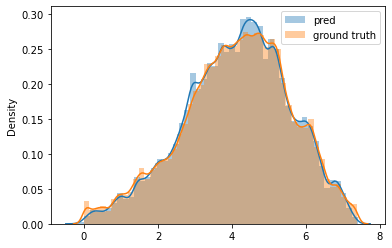

In [ ]:
# valid_score, models, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(best), return_info = True)

sns.distplot(y_pred_valid, label='pred')
sns.distplot(y_train, label='actual')
plt.legend()
plt.show()

In [ ]:
test_raw = test_raw[test_raw['timestamp'] <= '2017-03-31']
test = resample_data(test_raw, weather_test, building)
test = add_features(test)

In [ ]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test, num_iteration=model.best_iteration, predict_disable_shape_check=True)) / len(models)
    else:
        results += np.expm1(model.predict(test, num_iteration=model.best_iteration, predict_disable_shape_check=True)) / len(models)        

<ipython-input-51-7c99dbe64d06>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if  results == []:


In [ ]:
results

array([68.93443011, 37.77012998,  8.19746753, ..., 11.37962745,
       11.37962745, 11.37962745])

In [ ]:
# np.square(np.subtract(y_test,results)).mean()